In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [45]:
# Load the dataset
train_csv_path = '/Users/jamie/Desktop/Hult/bs2/data/train.csv'
df = pd.read_csv(train_csv_path)

# Splitting the PassengerId into group_num and ppl_num
df[['group_num', 'ppl_num']] = df['PassengerId'].str.split('_', expand=True)

# Finding the maximum number of people per group
group_max = df.groupby('group_num')['ppl_num'].max().reset_index(name='max_num')
df = pd.merge(df, group_max, on='group_num', how='left')
df['max_num'] = df['max_num'].astype(int)

# Function to fill null values in HomePlanet and Destination based on group_num
def fill_based_on_group(df, column):
    # Sort by group_num for efficient forward/backward filling within groups
    df = df.sort_values(by=['group_num', 'ppl_num'])
    # Forward fill and backward fill within each group
    df[column] = df.groupby('group_num')[column].ffill().bfill()
    # For any remaining, fill with the previous row's value
    df[column] = df[column].fillna(method='ffill')
    return df

# Filling nulls in HomePlanet and Destination
df = fill_based_on_group(df, 'HomePlanet')
df = fill_based_on_group(df, 'Destination')

# Generating a 'ticket' feature
df['ticket'] = df['HomePlanet'] + df['Destination']

# Getting dummies
df = pd.get_dummies(df, columns=['ticket'])

# Splitting the Cabin into class, row, and side
df[['cabin_class', 'cabin_row', 'cabin_side']] = df['Cabin'].str.split('/', expand=True)

# Filling nulls in cabin information using the same method as for HomePlanet and Destination
df = fill_based_on_group(df, 'cabin_class')
df = fill_based_on_group(df, 'cabin_row')
df = fill_based_on_group(df, 'cabin_side')

# Fill VIP nulls with False
df['VIP'] = df['VIP'].fillna(False)

# Fill Age nulls with a random int between 0 and 65
np.random.seed(666)  # For reproducibility

df['Age'] = df['Age'].fillna(pd.Series(np.random.randint(0, 67, size=len(df))))


'''
change
'''
# df['CryoSleep'] = df['CryoSleep'].fillna(df['Transported'])
df['expense'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
df['CryoSleep'] = df['CryoSleep'].fillna(df['expense'] == 0)

# Fill CrpoSleep with False where expense is not 0
df['CryoSleep'] = df['CryoSleep'].fillna(False)



# Creating age bins
df['AgeBin'] = pd.cut(df['Age'], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], right=False)

# Amenities columns to fill NA based on age bins
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Calculate median for each age bin and amenity
amenities_median = df.groupby('AgeBin')[amenities].median()

# Function to fill NA in amenities based on age bin
def fill_amenities_na(row, amenities, amenities_median):
    for amenity in amenities:
        if pd.isna(row[amenity]):
            if row['CryoSleep'] == True:
                fill_value = 0
            else:
                age_bin = row['AgeBin']
                fill_value = amenities_median.loc[age_bin, amenity]
            row[amenity] = fill_value
    return row

# Apply the function to fill NA values in amenities
df = df.apply(lambda row: fill_amenities_na(row, amenities, amenities_median), axis=1)

# Drop the temporary AgeBin column
df.drop('AgeBin', axis=1, inplace=True)
df['sum_expense'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

cabin_class_dummies = pd.get_dummies(df['cabin_class'], prefix='cabin_class')
cabin_side_dummies = pd.get_dummies(df['cabin_side'], prefix='cabin_side')

# Concatenating the dummy columns to the original dataframe
df = pd.concat([df, cabin_class_dummies, cabin_side_dummies], axis=1)

# Dropping the original 'cabin_class' and 'cabin_side' columns as corrected
df.drop(['cabin_class', 'cabin_side'], axis=1, inplace=True)
# Show the processed DataFrame structure
df.columns.values


/var/folders/ds/3p_1_pnx4y5f49xj8vp4dwlw0000gn/T/ipykernel_17051/279181074.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='ffill')
/var/folders/ds/3p_1_pnx4y5f49xj8vp4dwlw0000gn/T/ipykernel_17051/279181074.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='ffill')
/var/folders/ds/3p_1_pnx4y5f49xj8vp4dwlw0000gn/T/ipykernel_17051/279181074.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='ffill')
/var/folders/ds/3p_1_pnx4y5f49xj8vp4dwlw0000gn/T/ipykernel_17051/279181074.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() in

array(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination',
       'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Name', 'Transported', 'group_num', 'ppl_num', 'max_num',
       'ticket_Earth55 Cancri e', 'ticket_EarthPSO J318.5-22',
       'ticket_EarthTRAPPIST-1e', 'ticket_Europa55 Cancri e',
       'ticket_EuropaPSO J318.5-22', 'ticket_EuropaTRAPPIST-1e',
       'ticket_Mars55 Cancri e', 'ticket_MarsPSO J318.5-22',
       'ticket_MarsTRAPPIST-1e', 'cabin_row', 'expense', 'sum_expense',
       'cabin_class_A', 'cabin_class_B', 'cabin_class_C', 'cabin_class_D',
       'cabin_class_E', 'cabin_class_F', 'cabin_class_G', 'cabin_class_T',
       'cabin_side_P', 'cabin_side_S'], dtype=object)

In [28]:
# use
columns = ['PassengerId', 'HomePlanet','Cabin', 'Destination','Name']

In [29]:
df_01 = df.drop(columns, axis = 1)

In [30]:
df_01 = df_01.astype({col: 'int' for col in df_01.select_dtypes('bool').columns})

In [43]:
df_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CryoSleep                   8693 non-null   int64  
 1   Age                         8693 non-null   float64
 2   VIP                         8693 non-null   int64  
 3   RoomService                 8693 non-null   float64
 4   FoodCourt                   8693 non-null   float64
 5   ShoppingMall                8693 non-null   float64
 6   Spa                         8693 non-null   float64
 7   VRDeck                      8693 non-null   float64
 8   Transported                 8693 non-null   int64  
 9   group_num                   8693 non-null   object 
 10  ppl_num                     8693 non-null   object 
 11  max_num                     8693 non-null   int64  
 12  ticket_Earth55 Cancri e     8693 non-null   int64  
 13  ticket_EarthPSO J318.5-22   8693 

# try feature

In [40]:
df_01.columns.values

array(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'group_num',
       'ppl_num', 'max_num', 'ticket_Earth55 Cancri e',
       'ticket_EarthPSO J318.5-22', 'ticket_EarthTRAPPIST-1e',
       'ticket_Europa55 Cancri e', 'ticket_EuropaPSO J318.5-22',
       'ticket_EuropaTRAPPIST-1e', 'ticket_Mars55 Cancri e',
       'ticket_MarsPSO J318.5-22', 'ticket_MarsTRAPPIST-1e', 'cabin_row',
       'expense', 'sum_expense', 'cabin_class_A', 'cabin_class_B',
       'cabin_class_C', 'cabin_class_D', 'cabin_class_E', 'cabin_class_F',
       'cabin_class_G', 'cabin_class_T', 'cabin_side_P', 'cabin_side_S'],
      dtype=object)

# TRAINNING

## Random Forest

In [49]:
X = df_01.drop('Transported', axis=1) 
y = df_01['Transported']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
rf_grid_expanded = {
    'n_estimators': [200, 250, 300],
    'max_depth': [None, 1, 2, 3],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [3, 4, 5]
}
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize the GridSearchCV with the parameter grid and the classifier
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=rf_grid_expanded, cv=10, scoring='accuracy', verbose=5)

# Fit the GridSearchCV to the training data
grid_search_rf.fit(X_train, y_train)

# Extracting the best parameters
best_params_rf = grid_search_rf.best_params_

best_params_rf

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV 1/10] END max_depth=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=0.734 total time=   0.9s
[CV 2/10] END max_depth=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=0.769 total time=   0.9s
[CV 3/10] END max_depth=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=0.718 total time=   0.9s
[CV 4/10] END max_depth=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=0.757 total time=   0.9s
[CV 5/10] END max_depth=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=0.761 total time=   0.8s
[CV 6/10] END max_depth=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=0.753 total time=   0.8s
[CV 7/10] END max_depth=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=0.783 total time=   0.8s
[CV 8/10] END max_depth=None, min_samples_leaf=3, min_samples_split=10, n_estimat

{'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 300}

In [32]:
best_rf = {'max_depth': None, 
 'min_samples_leaf': 4, 
 'min_samples_split': 10,
 'n_estimators': 300}

In [50]:
rf_model = RandomForestClassifier(**best_rf)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7958596894767107
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       861
           1       0.79      0.81      0.80       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



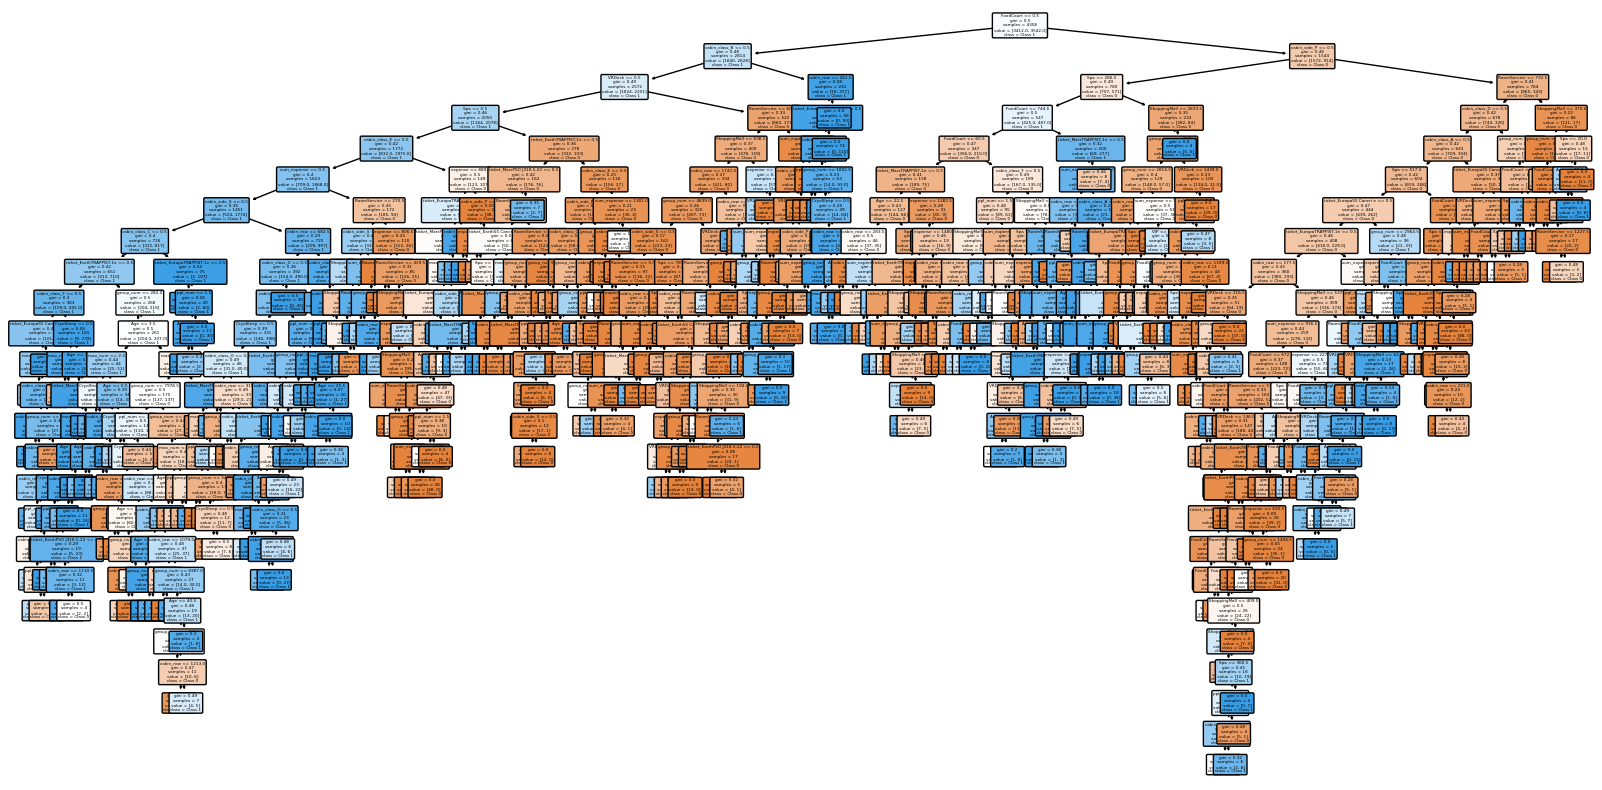

In [51]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Load the Iris dataset
iris = datasets.load_iris()

tree_to_plot = rf_model.estimators_[10]

plt.figure(figsize=(20,10))
plot_tree(tree_to_plot, 
          filled=True, 
          feature_names=X_train.columns,  # Assuming X_train is a DataFrame
          class_names=['Class 0', 'Class 1'],  # Adjust based on your problem
          rounded=True,
          proportion=False, 
          precision=2,
          fontsize=3)
plt.savefig('tree_high_res01.png', format='png', dpi=300)  
plt.show()

# Voting grid search

In [38]:
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier

# Define classifiers
bagging_base = BaggingClassifier(random_state=42)
gb_base = GradientBoostingClassifier(random_state=42)

# Parameter grids
bagging_param_grid = {
    'n_estimators': [50, 100],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0]
}

gb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

voting_param_grid = {
    'bagging__n_estimators': [50, 100],
    'bagging__max_samples': [0.5, 1.0],
    'bagging__max_features': [0.5, 1.0],
    'gb__n_estimators': [50, 100],
    'gb__learning_rate': [0.01, 0.1],
    'gb__max_depth': [3, 5]
}

# GridSearchCV
bagging_grid_search = GridSearchCV(bagging_base, bagging_param_grid, cv=5, scoring='accuracy')
gb_grid_search = GridSearchCV(gb_base, gb_param_grid, cv=5, scoring='accuracy')
voting_grid_search = GridSearchCV(estimator=VotingClassifier(estimators=[('bagging', bagging_base), ('gb', gb_base)], voting='soft'),param_grid=voting_param_grid, cv=5, scoring='accuracy')

# Fit the models
bagging_grid_search.fit(X_train, y_train)
gb_grid_search.fit(X_train, y_train)
voting_grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters for BaggingClassifier:", bagging_grid_search.best_params_)
print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)
print("Best parameters for Voting Classifier:", voting_grid_search.best_params_)

# Best scores
print("Best score for BaggingClassifier:", bagging_grid_search.best_score_)
print("Best score for Gradient Boosting:", gb_grid_search.best_score_)
print("Best score for Voting Classifier:", voting_grid_search.best_score_)

Best parameters for BaggingClassifier: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best parameters for Voting Classifier: {'bagging__max_features': 1.0, 'bagging__max_samples': 1.0, 'bagging__n_estimators': 50, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__n_estimators': 100}
Best score for BaggingClassifier: 0.8027050566592017
Best score for Gradient Boosting: 0.8103271286637117
Best score for Voting Classifier: 0.8123395517949407


In [39]:
from sklearn.metrics import accuracy_score
# Predictions with the best estimators
bagging_predictions = bagging_grid_search.best_estimator_.predict(X_test)
gb_predictions = gb_grid_search.best_estimator_.predict(X_test)
voting_predictions = voting_grid_search.best_estimator_.predict(X_test)

# Calculate accuracy for each model
bagging_accuracy = accuracy_score(y_test, bagging_predictions)
gb_accuracy = accuracy_score(y_test, gb_predictions)
voting_accuracy = accuracy_score(y_test, voting_predictions)

# Print accuracies
print(f"Accuracy for BaggingClassifier: {bagging_accuracy}")
print(f"Accuracy for Gradient Boosting: {gb_accuracy}")
print(f"Accuracy for Voting Classifier: {voting_accuracy}")


Accuracy for BaggingClassifier: 0.7987349051178838
Accuracy for Gradient Boosting: 0.7952846463484762
Accuracy for Voting Classifier: 0.8039102932719954


# voting tune

In [42]:
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier


bagging_base = BaggingClassifier(
    estimator=RandomForestClassifier(max_depth=40),  
    max_features=1.0,  
    max_samples=1.0,  
    n_estimators=50,  
    random_state=200
)

gb_base = GradientBoostingClassifier(
    learning_rate=0.1,  
    max_depth=4,  
    min_samples_split=6,  
    n_estimators=300,  
    subsample=0.8,  
    random_state=200
)
rf_base = RandomForestClassifier(
    max_depth=None, 
    min_samples_leaf=4,  
    min_samples_split=10,  
    n_estimators=300, 
    random_state=42
)
ada_base = AdaBoostClassifier(
    estimator=RandomForestClassifier(max_depth=3), 
    learning_rate = 0.1, n_estimators = 100)

voting_classifier = VotingClassifier(
    estimators=[
        ('bagging', bagging_base),
        ('rf', rf_base),
        ('gd', gb_base),
        ('ada',ada_base)
    ],
    voting='hard' 
)

voting_classifier.fit(X_train, y_train)
voting_pred = voting_classifier.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_pred)
print("Voting Classifier Accuracy:", voting_accuracy)

/Users/jamie/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Voting Classifier Accuracy: 0.7998849913743531


### Focus on Gradient Boosting
ensemble.GradientBoostingClassifier(*[, ...])Gradient Boosting for classification.

In [40]:
gb_param_grid_extended = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],  
    'min_samples_split': [2, 4, 6] 
}

gb_grid_search_extended = GridSearchCV(gb_base, gb_param_grid_extended, cv=10, scoring='accuracy', verbose=5)
gb_grid_search_extended.fit(X_train, y_train)

# Check the best parameters and score after the search is completed
print("Extended Grid Search Best Parameters:", gb_grid_search_extended.best_params_)
print("Extended Grid Search Best Score:", gb_grid_search_extended.best_score_)


Fitting 10 folds for each of 243 candidates, totalling 2430 fits
[CV 1/10] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.799 total time=   1.6s
[CV 2/10] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.784 total time=   1.5s
[CV 3/10] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.800 total time=   1.2s
[CV 4/10] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.816 total time=   1.1s
[CV 5/10] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.800 total time=   1.1s
[CV 6/10] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.797 total time=   1.1s
[CV 7/10] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.814 total time=   1.1s
[CV 

In [41]:
from sklearn.metrics import accuracy_score

gb_predictions = gb_grid_search.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print(f"Accuracy for Gradient Boosting: {gb_accuracy}")

Accuracy for Gradient Boosting: 0.7952846463484762


# test answer 

In [94]:

# Load the dataset
test_csv_path = '/Users/jamie/Desktop/Hult/bs2/data/test.csv'
df_test = pd.read_csv(test_csv_path)

# Splitting the PassengerId into group_num and ppl_num
df_test[['group_num', 'ppl_num']] = df_test['PassengerId'].str.split('_', expand=True)

# Finding the maximum number of people per group
group_max = df_test.groupby('group_num')['ppl_num'].max().reset_index(name='max_num')
df_test = pd.merge(df_test, group_max, on='group_num', how='left')
df_test['max_num'] = df_test['max_num'].astype(int)

# Function to fill null values in HomePlanet and Destination based on group_num
def fill_based_on_group(df, column):
    # Sort by group_num for efficient forward/backward filling within groups
    df = df.sort_values(by=['group_num', 'ppl_num'])
    # Forward fill and backward fill within each group
    df[column] = df.groupby('group_num')[column].ffill().bfill()
    # For any remaining, fill with the previous row's value
    df[column] = df[column].fillna(method='ffill')
    return df

# Filling nulls in HomePlanet and Destination
df_test = fill_based_on_group(df_test, 'HomePlanet')
df_test = fill_based_on_group(df_test, 'Destination')

# Generating a 'ticket' feature
df_test['ticket'] = df_test['HomePlanet'] + df_test['Destination']

# Getting dummies
df_test = pd.get_dummies(df_test, columns=['ticket'])

# Splitting the Cabin into class, row, and side
df_test[['cabin_class', 'cabin_row', 'cabin_side']] = df_test['Cabin'].str.split('/', expand=True)

# Filling nulls in cabin information using the same method as for HomePlanet and Destination
df_test = fill_based_on_group(df_test, 'cabin_class')
df_test = fill_based_on_group(df_test, 'cabin_row')
df_test = fill_based_on_group(df_test, 'cabin_side')

# Fill VIP nulls with False
df_test['VIP'] = df_test['VIP'].fillna(True)

# Fill Age nulls with a random int between 15 and 55
np.random.seed(42)  # For reproducibility
df_test['Age'] = df_test['Age'].fillna(pd.Series(np.random.randint(25, 41, size=len(df))))

# Fill CryoSleep nulls with the same value as Transported (assuming binary encoding needed)
df_test['CryoSleep'] = df_test['CryoSleep'].fillna(False)

# Creating age bins
df_test['AgeBin'] = pd.cut(df_test['Age'], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], right=False)

# Function to fill NA in amenities based on age bin
def fill_amenities_na(row):
    for amenity in amenities:
        if pd.isna(row[amenity]):
            age_bin = row['AgeBin']
            fill_value = amenities_median.loc[age_bin, amenity]
            row[amenity] = fill_value
    return row

# Apply the function to fill NA values in amenities
df_test = df_test.apply(fill_amenities_na, axis=1)

# Drop the temporary AgeBin column
df_test.drop('AgeBin', axis=1, inplace=True)
df_test['sum_expense'] = df_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

cabin_class_dummies = pd.get_dummies(df_test['cabin_class'], prefix='cabin_class')
cabin_side_dummies = pd.get_dummies(df_test['cabin_side'], prefix='cabin_side')

# Concatenating the dummy columns to the original dataframe
df_test = pd.concat([df_test, cabin_class_dummies, cabin_side_dummies], axis=1)

# Dropping the original 'cabin_class' and 'cabin_side' columns as corrected
df_test.drop(['cabin_class', 'cabin_side'], axis=1, inplace=True)


columns = ['PassengerId', 'HomePlanet','Cabin', 'Destination','Name']
df_test_01 = df_test.drop(columns, axis = 1)
df_test_01 = df_test_01.astype({col: 'int' for col in df_test_01.select_dtypes('bool').columns})

/var/folders/ds/3p_1_pnx4y5f49xj8vp4dwlw0000gn/T/ipykernel_12712/3080064253.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
/var/folders/ds/3p_1_pnx4y5f49xj8vp4dwlw0000gn/T/ipykernel_12712/3080064253.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
/var/folders/ds/3p_1_pnx4y5f49xj8vp4dwlw0000gn/T/ipykernel_12712/3080064253.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
/var/folders/ds/3p_1_pnx4y5f49xj8vp4dwlw0000gn/T/ipykernel_12712/3080064253.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
/var/folders/ds/3p_1_pnx4y5f49xj8vp4dwlw0000gn/T/ipykernel_12712/3080064253.py:20: FutureWarning: Series.fillna with 'method' is depreca

In [77]:
ans_pred = gb_grid_search.best_estimator_.predict(df_test_01)

In [78]:
ans = df_test['PassengerId']
ans_df = pd.DataFrame({
    'PassengerId': ans
})
ans_df["Transported"] = ans_pred
ans_df['Transported'] = ans_df['Transported'].replace({1: 'True', 0: 'False'})
ans_df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [ ]:
ans_df.to_csv('/predict_csv/test_new07.csv', index=False)

##### try voting

In [80]:
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [91]:
bagging_base = BaggingClassifier( max_features=1,max_samples=0.5,n_estimators=200,random_state=200)
gb_base = GradientBoostingClassifier(random_state=200)
rd_base = RandomForestClassifier(random_state=42)
ada_base = AdaBoostClassifier(learning_rate=0.1,n_estimators=100, algorithm='SAMME', random_state=200)

In [92]:
param_grid = {
    'bagging__n_estimators': [100, 200],
    'bagging__max_samples': [0.5, 1.0],
    'gb__n_estimators': [100, 150],
    'gb__learning_rate': [0.1, 0.2],
    'rd__n_estimators': [200, 350],
    'rd__max_depth': [20, 40],
    'ada__n_estimators': [50, 100],
    'ada__learning_rate': [0.05, 0.1]
}

In [93]:
voting_classifier = VotingClassifier(estimators=[
    ('bagging', bagging_base),
    ('gb', gb_base),
    ('ada', ada_base),
    ('rd', rd_base)
], voting='hard')

In [98]:
grid_search = GridSearchCV(estimator=voting_classifier, param_grid=param_grid, cv=10, scoring='accuracy', verbose=3, n_jobs=1)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 256 candidates, totalling 2560 fits
[CV 1/10] END ada__learning_rate=0.05, ada__n_estimators=50, bagging__max_samples=0.5, bagging__n_estimators=100, gb__learning_rate=0.1, gb__n_estimators=100, rd__max_depth=20, rd__n_estimators=200;, score=0.759 total time=   4.5s
[CV 2/10] END ada__learning_rate=0.05, ada__n_estimators=50, bagging__max_samples=0.5, bagging__n_estimators=100, gb__learning_rate=0.1, gb__n_estimators=100, rd__max_depth=20, rd__n_estimators=200;, score=0.769 total time=   4.3s
[CV 3/10] END ada__learning_rate=0.05, ada__n_estimators=50, bagging__max_samples=0.5, bagging__n_estimators=100, gb__learning_rate=0.1, gb__n_estimators=100, rd__max_depth=20, rd__n_estimators=200;, score=0.759 total time=   4.3s
[CV 4/10] END ada__learning_rate=0.05, ada__n_estimators=50, bagging__max_samples=0.5, bagging__n_estimators=100, gb__learning_rate=0.1, gb__n_estimators=100, rd__max_depth=20, rd__n_estimators=200;, score=0.789 total time=   4.2s
[CV 5/10] E

GridSearchCV(cv=10,
             estimator=VotingClassifier(estimators=[('bagging',
                                                     BaggingClassifier(max_features=1,
                                                                       max_samples=0.5,
                                                                       n_estimators=200,
                                                                       random_state=200)),
                                                    ('gb',
                                                     GradientBoostingClassifier(random_state=200)),
                                                    ('ada',
                                                     AdaBoostClassifier(algorithm='SAMME',
                                                                        learning_rate=0.1,
                                                                        n_estimators=100,
                                                                        random_state=200)),
                                                    ('rd',
                                                     RandomForestClassifier(random_state=42))]),
             n_jobs=1,
             param_grid={'ada__learning_rate': [0.05, 0.1],
                         'ada__n_estimators': [50, 100],
                         'bagging__max_samples': [0.5, 1.0],
                         'bagging__n_estimators': [100, 200],
                         'gb__learning_rate': [0.1, 0.2],
                         'gb__n_estimators': [100, 150],
                         'rd__max_depth': [20, 40],
                         'rd__n_estimators': [200, 350]},
             scoring='accuracy', verbose=3)

In [99]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'ada__learning_rate': 0.1, 'ada__n_estimators': 100, 'bagging__max_samples': 0.5, 'bagging__n_estimators': 100, 'gb__learning_rate': 0.2, 'gb__n_estimators': 100, 'rd__max_depth': 20, 'rd__n_estimators': 350}
Best Score: 0.785595592491524


In [100]:
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy}")

Test Set Accuracy: 0.777458309373203
